In [21]:
!pip install transformers torch datasets scikit-learn pandas imblearn nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Libraries

In [75]:
import pandas as pd
import numpy as np
import re
import nltk
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW
from transformers import EarlyStoppingCallback
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Download stopwords for preprocessing
nltk.download("stopwords")
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load dataset

In [76]:
df = pd.read_csv("/content/drive/MyDrive/DSGP/dataset/intents_final.csv")

In [77]:
df = df[["intent", "examples"]]
df.dropna(inplace=True)

<ipython-input-77-45f8b850bd5a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [78]:
df.shape

(1112, 2)

In [79]:
# Shuffle dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [80]:
print("Dataset Sample:")
print(df.head())

Dataset Sample:
               intent                                      examples
0               greet                                       namaste
1             goodbye                                        cheers
2  bird_info_generate  Describe the aerial acrobatics of bee-eaters
3              affirm                    Yes thatâ€™s what I meant!
4                deny                                     no chance


## Convert intents into numerical values

In [81]:
label_encoder = LabelEncoder()
df["intent"] = label_encoder.fit_transform(df["intent"])

### Label Mapping

In [82]:
# Store Label Mapping for Future Use
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'affirm': 0, 'bird_info_generate': 1, 'bot_challenge': 2, 'deny': 3, 'goodbye': 4, 'greet': 5, 'image_classification': 6, 'keyword_finder': 7, 'mood_great': 8, 'mood_unhappy': 9, 'range_prediction': 10, 'thank_you': 11}


## Random Oversampling

In [83]:
X = df["examples"]
y = df["intent"]

# Apply Random Oversampling to balance classes
oversample = RandomOverSampler(sampling_strategy="auto")
X_resampled, y_resampled = oversample.fit_resample(X.values.reshape(-1, 1), y)

In [84]:
# Convert Back to DataFrame
df_balanced = pd.DataFrame({"examples": X_resampled.flatten(), "intent": y_resampled})
print("Balanced Class Distribution:\n", df_balanced["intent"].value_counts())

Balanced Class Distribution:
 intent
5     105
4     105
1     105
0     105
3     105
10    105
6     105
2     105
7     105
8     105
9     105
11    105
Name: count, dtype: int64


## Dataset Preprocessing

In [85]:
stop_words = set(stopwords.words("english"))

In [86]:
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove special characters
    text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

In [87]:
# Apply text preprocessing
df_balanced["examples"] = df_balanced["examples"].apply(preprocess_text)

print("Text Preprocessing Complete!")
print(df_balanced.head())

Text Preprocessing Complete!
                               examples  intent
0                               namaste       5
1                                cheers       4
2  describe aerial acrobatics beeeaters       1
3                       yes thats meant       0
4                                chance       3


## Split Dataset

In [88]:
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced["examples"], df_balanced["intent"], test_size=0.2, random_state=42
)

### Load BERT Tokenizer

In [89]:
# ✅ Load BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# ✅ Tokenize Data
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, return_tensors="pt")
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, return_tensors="pt")

## Create Dataset Objects

In [90]:
class IntentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

# Convert Intent Labels to Numeric
train_labels = y_train.tolist()
test_labels = y_test.tolist()

# Create Dataset Objects
train_dataset = IntentDataset(train_encodings, train_labels)
test_dataset = IntentDataset(test_encodings, test_labels)


## Build BERT model

In [91]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(label_mapping)
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [92]:
training_args = TrainingArguments(
    output_dir="./bert_intent_model",
    num_train_epochs=15,  # Increase if needed
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [93]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="weighted", zero_division=1
    )
    acc = accuracy_score(labels, preds)

    print(f"Train Accuracy: {acc}")  # Log training accuracy

    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

In [94]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],  # Stop early if overfitting
)

# Train Model
trainer.train()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: harindu-20230712 (harindu-20230712-informatics-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.409900,2.361804,0.158730,0.088752,0.714257,0.158730
2,2.071100,1.957169,0.432540,0.404931,0.575094,0.432540
3,1.519000,1.224547,0.765873,0.756470,0.824726,0.765873
4,0.750800,0.617135,0.853175,0.851693,0.855578,0.853175
5,0.344800,0.449053,0.880952,0.881215,0.893429,0.880952
6,0.180300,0.381711,0.908730,0.909067,0.919113,0.908730
7,0.199900,0.467187,0.896825,0.896650,0.905498,0.896825
8,0.116000,0.399851,0.916667,0.917933,0.927450,0.916667
9,0.139700,0.398333,0.912698,0.914390,0.925178,0.912698
10,0.058700,0.406189,0.900794,0.901535,0.907929,0.900794


Train Accuracy: 0.15873015873015872
Train Accuracy: 0.43253968253968256
Train Accuracy: 0.7658730158730159
Train Accuracy: 0.8531746031746031
Train Accuracy: 0.8809523809523809
Train Accuracy: 0.9087301587301587
Train Accuracy: 0.8968253968253969
Train Accuracy: 0.9166666666666666
Train Accuracy: 0.9126984126984127
Train Accuracy: 0.9007936507936508


TrainOutput(global_step=630, training_loss=0.85505579587013, metrics={'train_runtime': 3171.4819, 'train_samples_per_second': 3.178, 'train_steps_per_second': 0.199, 'total_flos': 62165567923200.0, 'train_loss': 0.85505579587013, 'epoch': 10.0})

In [95]:
eval_results = trainer.evaluate()
print("Evaluation Results:")
print(f"Accuracy: {eval_results['eval_accuracy']}")
print(f"Precision: {eval_results['eval_precision']}")
print(f"Recall: {eval_results['eval_recall']}")
print(f"F1 Score: {eval_results['eval_f1']}")

Train Accuracy: 0.9166666666666666
Evaluation Results:
Accuracy: 0.9166666666666666
Precision: 0.9274496537063783
Recall: 0.9166666666666666
F1 Score: 0.9179325491626122


In [97]:
from sklearn.metrics import classification_report

# ✅ Make Predictions
y_pred_logits = trainer.predict(test_dataset).predictions
y_pred = y_pred_logits.argmax(-1)

# Print Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_mapping.keys()))

Train Accuracy: 0.9166666666666666
Classification Report:
                      precision    recall  f1-score   support

              affirm       0.94      0.80      0.86        20
  bird_info_generate       0.95      0.95      0.95        19
       bot_challenge       0.90      0.96      0.93        27
                deny       0.65      1.00      0.79        15
             goodbye       0.90      0.82      0.86        22
               greet       1.00      0.81      0.90        16
image_classification       1.00      1.00      1.00        28
      keyword_finder       0.95      1.00      0.98        21
          mood_great       0.82      0.88      0.85        16
        mood_unhappy       0.88      0.83      0.86        18
    range_prediction       1.00      1.00      1.00        28
           thank_you       1.00      0.86      0.93        22

            accuracy                           0.92       252
           macro avg       0.92      0.91      0.91       252
        we

Train Accuracy: 0.9166666666666666


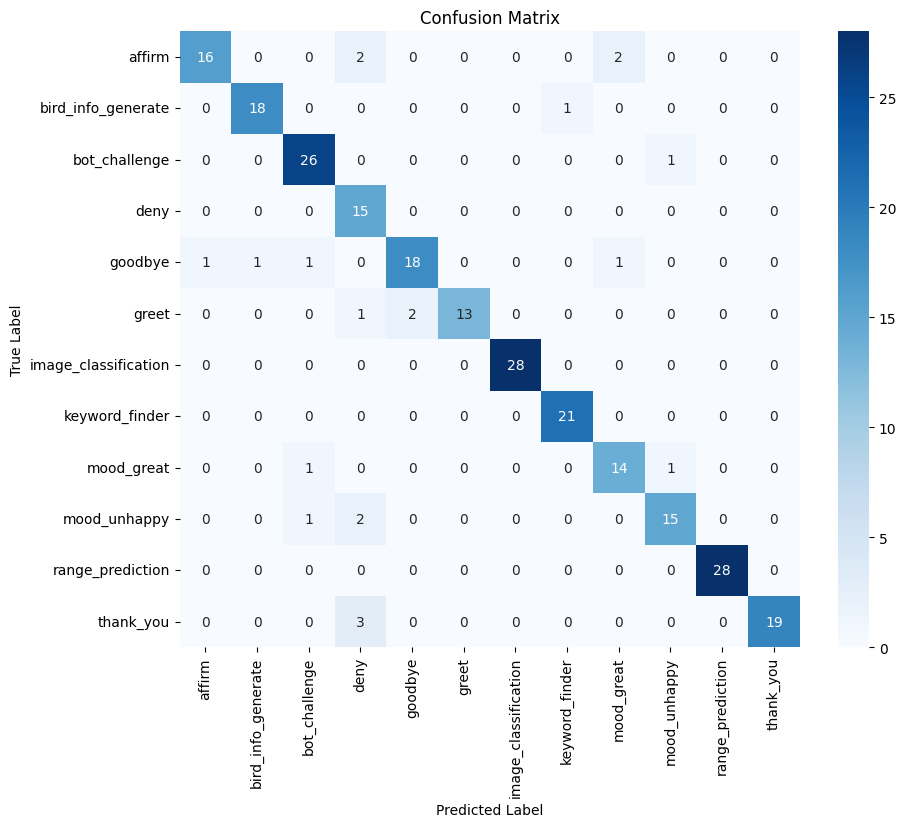

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get Predictions
y_pred_logits = trainer.predict(test_dataset).predictions
y_pred = y_pred_logits.argmax(-1)

# Compute Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [100]:
# Define save path
model_save_path = "/content/drive/MyDrive/DSGP/models/BERT_model_2"

# Save the trained model
trainer.save_model(model_save_path)

# Save the tokenizer (needed for inference)
tokenizer.save_pretrained(model_save_path)

print(f"✅ Model saved successfully at: {model_save_path}")


✅ Model saved successfully at: /content/drive/MyDrive/DSGP/models/BERT_model_2
